In [4]:
import os, math
import numpy as np
from itertools import islice
from matplotlib import pyplot as plt

In [5]:
DATA_FOLDER = r'C:\Users\datsh\Desktop\Autopilot-TensorFlow-master\driving_dataset'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')
LIMIT = None

split = 0.8
x, y = list(), list()

with open(TRAIN_FILE) as fp:
    for line in islice(fp, LIMIT):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        
        x.append(full_path)
        y.append(float(angle)*(math.pi)*(1/180))

y = np.array(y)

(array([  26.,   12.,   23.,   23.,   16.,   25.,    7.,    4.,    7.,
           3.,    3.,    5.,    4.,    4.,    4.,    5.,    5.,   17.,
          18.,   21.,   67.,   41.,   17.,   19.,   15.,   15.,   16.,
          24.,   25.,  152.,  280.,  126.,  325.,  759., 2609.,  944.,
        1806.,  727.,  245.,  258.,  132.,   30.,   20.,   53.,   75.,
          46.,    6.,    4.,    5.,    9.]),
 array([-2.79130507, -2.70985405, -2.62840302, -2.546952  , -2.46550097,
        -2.38404995, -2.30259892, -2.22114789, -2.13969687, -2.05824584,
        -1.97679482, -1.89534379, -1.81389277, -1.73244174, -1.65099072,
        -1.56953969, -1.48808866, -1.40663764, -1.32518661, -1.24373559,
        -1.16228456, -1.08083354, -0.99938251, -0.91793149, -0.83648046,
        -0.75502943, -0.67357841, -0.59212738, -0.51067636, -0.42922533,
        -0.34777431, -0.26632328, -0.18487226, -0.10342123, -0.0219702 ,
         0.05948082,  0.14093185,  0.22238287,  0.3038339 ,  0.38528492,
         0.46673

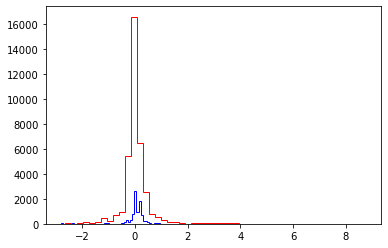

In [6]:
# Splitting the dataset and plotting the respective histograms

split_index = int(len(y)*0.8)
y_train = y[:split_index]
y_test = y[split_index:]

plt.hist(y_train, bins=50, color='red', histtype='step')
plt.hist(y_test, bins=50, color='blue', histtype='step')

In [7]:
# Regression problem

y_mean_train = np.mean(y_train)
print(np.mean(np.square(y_test - y_mean_train)))
print(np.mean(np.square(y_test - 0.0)))

0.19112687369474946
0.19089104348993743


In [ ]:
# (STEP-1) Code for training the data (Necessary additional python files to be linked)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model
import cv2
from subprocess import call

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.8})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
      "--> tensorboard --logdir=./logs " \
      "\nThen open http://0.0.0.0:6006/ into your web browser")


In [ ]:
# (STEP-2) Running the code (Necessary additional python files to be linked)

#check if on windows OS
windows = False
if os.name == 'nt':
    windows = True

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

cap = cv2.VideoCapture(0)
while(cv2.waitKey(10) != ord('q')):
    ret, frame = cap.read()
    image = cv2.resize(frame, (200, 66)) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180 / 3.14159265
    if not windows:
        call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow('frame', frame)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)

cap.release()
cv2.destroyAllWindows()

In [ ]:
# (STEP-3) Running the dataset (Necessary additional python files to be linked)

#check if on windows OS
windows = False
if os.name == 'nt':
    windows = True

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

i = 0
while(cv2.waitKey(10) != ord('q')):
    full_image = cv2.imread("driving_dataset/" + str(i) + ".jpg")
    image = cv2.resize(full_image[-150:], (200, 66)) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / 3.14159265
    if not windows:
        call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.imshow("frame", full_image)
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()
